In [1]:
import orbax.checkpoint as ocp
from ml_collections import ConfigDict
from pathlib import Path
from utils import prepare_test_dataset
from dataset_utils import get_dataset
from jax import random
from models.utils import sample_gaussian

import models.ClassifierGFZ as ClassifierGFZ
import models.ClassifierDFZ as ClassifierDFZ

checkpoint_path = "dfz-2-epochs-first-try-1"
path = Path.cwd() / Path(f"checkpoints") / Path(checkpoint_path)
checkpoint = ocp.PyTreeCheckpointer().restore(path, item=None)

config = ConfigDict(checkpoint["config"])
dataset_config = ConfigDict(checkpoint["dataset_config"])

if config.model_name == "GFZ":
    classifier = ClassifierGFZ
elif config.model_name == "DFZ":
    classifier = ClassifierDFZ
else:
    raise NotImplementedError(config.model_name)

_, test_ds = get_dataset(config.dataset)
test_images, test_labels = prepare_test_dataset(
    test_ds, dataset_config
    )

trained_params = checkpoint["params"]

log_likelyhood_fn = classifier.log_likelyhood_A

test_key = random.PRNGKey(config.seed)

test_key, model, _ = classifier.create_and_init(
    test_key, config, dataset_config
)

/Users/alexandrelutt/Desktop/Travail/ENPC/3A/MVA/Probabilistic Graphical Models/adversarial-attacks-on-generative-classifiers/.venv/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1346: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


In [2]:
from flax import linen as nn
import jax
from jax import jacrev
import numpy as np
from functools import partial
from jax.scipy.special import logsumexp
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

def init_data(test_key, n_samples=10):
    idx = np.random.choice(range(len(test_images)), n_samples, replace=False)

    all_xs = test_images[idx]
    true_ys = test_labels[idx]
    true_labels = np.argmax(true_ys, axis=1)

    K = model.K
    batch_size = n_samples
    test_key, epsilons = sample_gaussian(test_key, (batch_size, model.n_classes * K, model.d_latent))
    epsilons = epsilons[:n_samples*model.n_classes]
    all_ys = nn.one_hot(jnp.repeat(jnp.arange(model.n_classes), K), model.n_classes, dtype=jnp.float32)
    
    return all_xs, true_labels, epsilons, all_ys, K, test_key

def get_model_output(x, epsilon, y, K):
    z, logit_q_z_xy, logit_p_x_z, logit_p_y_xz = jax.vmap(
            partial(model.apply, {'params': trained_params}, train=False),
            in_axes=(None, 0, 0)
        )(x, y, epsilon)

    ll = log_likelyhood_fn(
            z, logit_q_z_xy, logit_p_x_z, logit_p_y_xz
        ).reshape(model.n_classes, K)
    ll = logsumexp(ll, axis=1) - np.log(K)
    return ll

def get_model_jacobian(x, epsilon, y, K):
    return jacrev(get_model_output, argnums=0)(x, epsilon, y, K)

def map_label_to_name(y):
    labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    return labels[y]

In [3]:
class DeepFool():
    def __init__(self, model, max_iter=10, learning_rate=1, p=2):
        self.model = model
        self.n_classes = model.n_classes
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        assert p > 1 
        self.p = p
        if self.p == np.inf:
            self.q = 1
        else:
            self.q = self.p/(self.p-1)

    def qnorm(self, x):
        return np.linalg.norm(x.flatten(), self.q)

    def get_label(self, x, epsilon):
        val = get_model_output(x, epsilon, self.y, self.K)
        return np.argmax(val)

    def get_likelihoods_and_gradients(self, x, epsilon):
        J = get_model_jacobian(x, epsilon, self.y, self.K)
        val = get_model_output(x, epsilon, self.y, self.K)
        return val, J

    def get_perturbation(self, x, epsilon, all_ys, K):
        corrupted_x = x.copy()
        self.y = all_ys
        self.K = K
        new_label = self.get_label(corrupted_x, epsilon)
        k = self.get_label(x, epsilon)
        for _ in range(self.max_iter):
            best_pert = np.inf
            likelihoods, gradients = self.get_likelihoods_and_gradients(corrupted_x, epsilon)
            for j in range(self.n_classes):
                if j != k:
                    w_j = gradients[j] - gradients[k]
                    f_j = likelihoods[j] - likelihoods[k]
                    pert = np.abs(f_j) / self.qnorm(w_j)
                    if pert < best_pert:
                        w = w_j
                        f = f_j
            r_i = (np.abs(f) / self.qnorm(w)**self.q) * (np.sign(w) * np.abs(w)**(self.q-1))
            corrupted_x = corrupted_x + self.learning_rate*r_i
            new_label = self.get_label(corrupted_x, epsilon)
            if new_label != k:
                break
        if new_label == k:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
        else:
            perturbation_norm = np.linalg.norm(corrupted_x - x)/np.linalg.norm(x)
        return corrupted_x, new_label, perturbation_norm

In [4]:
class FastGradientSign():
    def __init__(self, model, eta=0.3):
        self.model = model
        self.eta = eta

    def get_likelihoods_and_gradients(self, x, epsilon):
        J = get_model_jacobian(x, epsilon, self.y, self.K)
        val = get_model_output(x, epsilon, self.y, self.K)
        return val, J
    
    def get_label(self, x, epsilon):
        val = get_model_output(x, epsilon, self.y, self.K)
        return np.argmax(val)

    def get_perturbation(self, x, epsilon, all_ys, K):
        corrupted_x = x.copy()  
        self.y = all_ys
        self.K = K
        original_label = self.get_label(x, epsilon)
        _, gradients = self.get_likelihoods_and_gradients(corrupted_x, epsilon)
        perturbations = np.array([self.eta * np.sign(g) for g in gradients])
        perturbated_labels = np.array([self.get_label(x+p, epsilon) for p in perturbations])
        different_labels_ids = np.where(perturbated_labels != original_label)
        if len(different_labels_ids[0]) == 0:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
            new_label = original_label
            smallest_perturbation = np.argmin(np.linalg.norm(perturbations, axis=0))
            corrupted_x = x + smallest_perturbation
        else:
            different_labels_norms = np.array([np.linalg.norm(p) for p in perturbations])[different_labels_ids]
            corrupted_x = x + perturbations[np.argmin(different_labels_norms)]
            new_label = self.get_label(corrupted_x, epsilon)
            perturbation_norm = np.linalg.norm(corrupted_x - x)/np.linalg.norm(x)
        return corrupted_x, new_label, perturbation_norm

In [5]:
def get_average_performance(corruption_model, all_xs, epsilons, all_ys, K):
    perturbation_norms = []
    n_samples = len(all_xs)
    for i in tqdm(range(n_samples)):
        x = all_xs[i]
        epsilon = epsilons[i]
        _, _, perturbation_norm = corruption_model.get_perturbation(x, epsilon, all_ys, K)
        perturbation_norms.append(perturbation_norm)
    return np.array(perturbation_norms)

In [6]:
n_samples = 100
all_xs, true_labels, epsilons, all_ys, K, test_key = init_data(test_key, n_samples=n_samples)

corruption_model = DeepFool(model)

perturbation_norms_deepfool = get_average_performance(corruption_model, all_xs, epsilons, all_ys, K)
perturbation_norms_successful_deepfool = perturbation_norms_deepfool[perturbation_norms_deepfool != -1]
n_successful_deepfool = len(perturbation_norms_successful_deepfool)

print(f'Average perturbation norm of DeepFool model (on {n_successful_deepfool} successful samples): {np.mean(perturbation_norms_successful_deepfool):>.4f}')

 94%|█████████▍| 94/100 [02:45<00:27,  4.53s/it]

100%|██████████| 100/100 [02:55<00:00,  1.75s/it]

Average perturbation norm of DeepFool model (on 99 successful samples): 0.2380


In [8]:
corruption_model = FastGradientSign(model, eta=0.3)

perturbation_norms_fgs = get_average_performance(corruption_model, all_xs, epsilons, all_ys, K)
perturbation_norms_successful_fgs = perturbation_norms_fgs[perturbation_norms_fgs != -1]
n_successful_fgs = len(perturbation_norms_successful_fgs)

print(f'Average perturbation norm of Fast Gradient Sign model (on {n_successful_fgs} successful samples): {np.mean(perturbation_norms_successful_fgs):>.4f}')

 33%|███▎      | 33/100 [01:56<03:50,  3.44s/it]

 70%|███████   | 70/100 [04:15<01:45,  3.51s/it]

 96%|█████████▌| 96/100 [05:47<00:13,  3.45s/it]

100%|██████████| 100/100 [06:01<00:00,  3.62s/it]

Average perturbation norm of Fast Gradient Sign model (on 97 successful samples): 0.7795


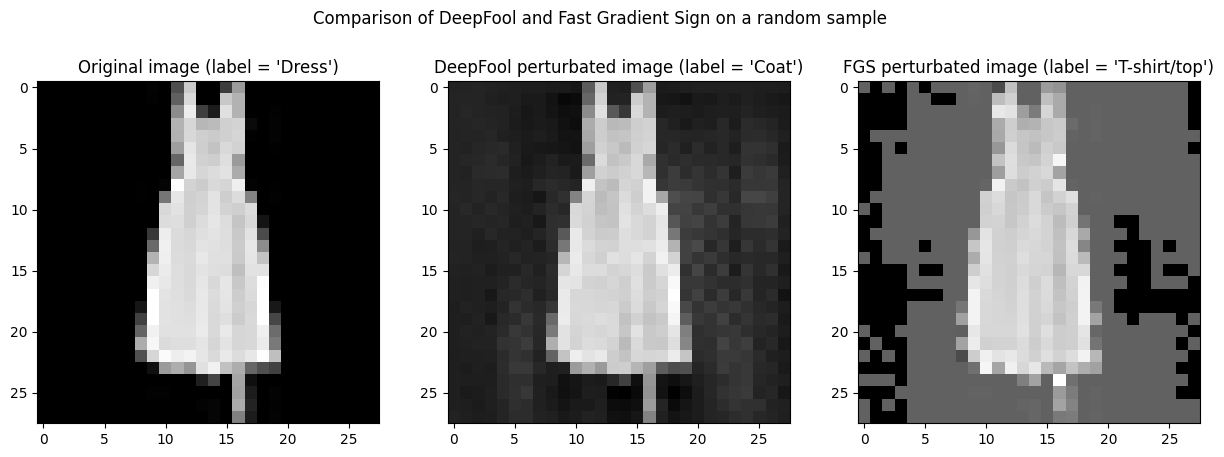

In [13]:
i = np.random.choice(range(n_samples))
x = all_xs[i]
true_label = true_labels[i]
test_key, epsilons = sample_gaussian(test_key, (1, model.n_classes * K, model.d_latent))
epsilon = epsilons[0]

deepfool_model = DeepFool(model, learning_rate=0.2)
corrupted_x_deepfool, new_label_deepfool, perturbation_norm_deepfool = deepfool_model.get_perturbation(x, epsilon, all_ys, K)

fgs_model = FastGradientSign(model, eta=0.2)
corrupted_x_fgs, new_label_fgs, perturbation_norm_fgs = fgs_model.get_perturbation(x, epsilon, all_ys, K)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x.reshape(28, 28), cmap="gray")
axs[0].set_title(f"Original image (label = '{map_label_to_name(true_label)}')")

axs[1].imshow(corrupted_x_deepfool.reshape(28, 28), cmap="gray")
axs[1].set_title(f"DeepFool perturbated image (label = '{map_label_to_name(new_label_deepfool)}')")

axs[2].imshow(corrupted_x_fgs.reshape(28, 28), cmap="gray")
axs[2].set_title(f"FGS perturbated image (label = '{map_label_to_name(new_label_fgs)}')")

fig.suptitle(f"Comparison of DeepFool and Fast Gradient Sign on a random sample")
plt.show()